# XOR Problem and the Need for Depth

## The XOR Problem: Historical Context

The XOR (exclusive OR) problem exposed fundamental limitations of **true** single-layer perceptrons, leading to the "AI winter" of the 1970s after Minsky and Papert's critique. This simple problem reveals why depth is essential in neural networks.

**XOR Truth Table:**
```
x₁  x₂  │  y
────────┼────
 0   0  │  0
 0   1  │  1  
 1   0  │  1
 1   1  │  0
```

**Key insight**: XOR is not linearly separable - no single line can separate the classes.

**Historical Note**: A true single-layer perceptron has NO hidden layers - just direct input-to-output connections. This is what Minsky and Papert showed cannot solve XOR.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use('default')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (14, 10)})

# XOR dataset
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y_xor = np.array([[0], [1], [1], [0]], dtype=np.float32)

X_xor_tensor = torch.tensor(X_xor)
y_xor_tensor = torch.tensor(y_xor)

print("XOR Dataset:")
for i in range(4):
    print(f"({X_xor[i,0]}, {X_xor[i,1]}) → {y_xor[i,0]}")

XOR Dataset:
(0.0, 0.0) → 0.0
(0.0, 1.0) → 1.0
(1.0, 0.0) → 1.0
(1.0, 1.0) → 0.0


## Why Single Layer Fails: Geometric Intuition

A **true** single-layer perceptron can only create linear decision boundaries. The XOR problem requires a non-linear boundary that no single line can provide.

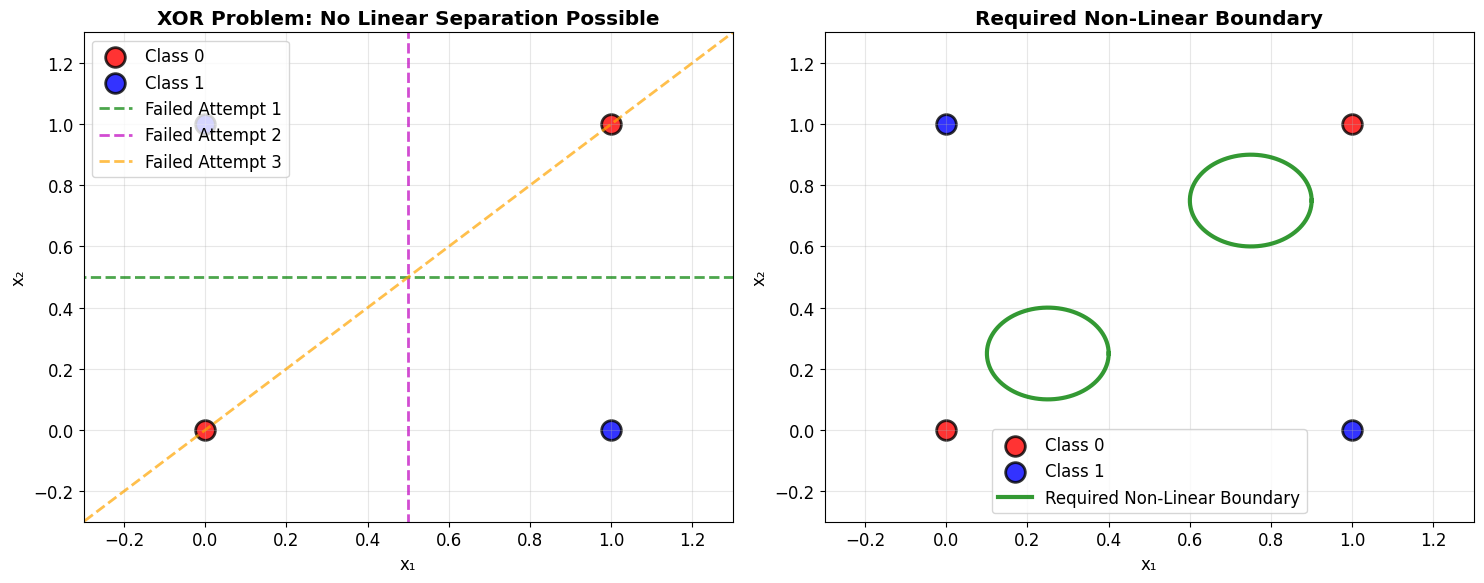

In [10]:
# Visualize XOR problem
def plot_xor_problem():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: XOR data points with failed linear separation attempts
    colors = ['red', 'blue']
    labels = ['Class 0', 'Class 1']
    
    for i in range(2):
        mask = y_xor.flatten() == i
        ax1.scatter(X_xor[mask, 0], X_xor[mask, 1], 
                   c=colors[i], s=200, alpha=0.8, 
                   label=labels[i], edgecolors='black', linewidth=2)
    
    # Try to draw separating lines (all fail)
    x_line = np.linspace(-0.5, 1.5, 100)
    ax1.plot(x_line, 0.5 * np.ones_like(x_line), 'g--', linewidth=2, alpha=0.7, label='Failed Attempt 1')
    ax1.plot(0.5 * np.ones_like(x_line), x_line, 'm--', linewidth=2, alpha=0.7, label='Failed Attempt 2')
    ax1.plot(x_line, x_line, 'orange', linestyle='--', linewidth=2, alpha=0.7, label='Failed Attempt 3')
    
    ax1.set_xlim(-0.3, 1.3)
    ax1.set_ylim(-0.3, 1.3)
    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    ax1.set_title('XOR Problem: No Linear Separation Possible', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Required non-linear boundary
    for i in range(2):
        mask = y_xor.flatten() == i
        ax2.scatter(X_xor[mask, 0], X_xor[mask, 1], 
                   c=colors[i], s=200, alpha=0.8, 
                   label=labels[i], edgecolors='black', linewidth=2)
    
    # Draw the required non-linear boundary (conceptual)
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle1 = 0.25 + 0.15*np.cos(theta)
    y_circle1 = 0.25 + 0.15*np.sin(theta)
    x_circle2 = 0.75 + 0.15*np.cos(theta)
    y_circle2 = 0.75 + 0.15*np.sin(theta)
    
    ax2.plot(x_circle1, y_circle1, 'g-', linewidth=3, alpha=0.8, label='Required Non-Linear Boundary')
    ax2.plot(x_circle2, y_circle2, 'g-', linewidth=3, alpha=0.8)
    
    ax2.set_xlim(-0.3, 1.3)
    ax2.set_ylim(-0.3, 1.3)
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('x₂')
    ax2.set_title('Required Non-Linear Boundary', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_xor_problem()

## Network Architectures: The Critical Difference

Let's define the architectures correctly to demonstrate the historical problem:

In [ ]:
# TRUE Single Layer Perceptron (what Minsky & Papert analyzed)
class TrueSingleLayerPerceptron(nn.Module):
    """A TRUE single-layer perceptron with NO hidden layers.
    Architecture: Input → Output (direct connection)
    This is what cannot solve XOR!
    """
    def __init__(self):
        super().__init__()
        # Direct connection from 2 inputs to 1 output - NO hidden layer
        self.layer = nn.Linear(2, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.layer(x))
    
    def get_weights(self):
        """Return weights for analysis"""
        return self.layer.weight.data, self.layer.bias.data

# Multi-Layer Perceptron (what actually solves XOR)
class MultiLayerPerceptron(nn.Module):
    """A multi-layer perceptron with one hidden layer.
    Architecture: Input → Hidden → Output
    This CAN solve XOR!
    """
    def __init__(self, hidden_size=4):
        super().__init__()
        self.hidden = nn.Linear(2, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return torch.sigmoid(x)

def train_xor_model(model, X, y, epochs=5000, lr=1.0):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    losses = []
    
    for epoch in range(epochs):
        pred = model(X)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            accuracy = ((pred > 0.5).float() == y).float().mean()
            print(f'Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.4f}')
    
    return losses

print("Network architectures defined:")
print("1. TrueSingleLayerPerceptron: Input → Output (NO hidden layer)")
print("2. MultiLayerPerceptron: Input → Hidden → Output (1 hidden layer)")

Network architectures defined:
1. TrueSingleLayerPerceptron: Input → Output (NO hidden layer)
2. MultiLayerPerceptron: Input → Hidden → Output (1 hidden layer)
3. DeepNetwork: Input → Hidden → Hidden → Output (2 hidden layers)


## Demonstrating the Historical Problem

Now let's train the TRUE single-layer perceptron and watch it fail to solve XOR:

In [12]:
# Train TRUE single layer perceptron (this SHOULD and WILL fail!)
print("=" * 70)
print("TRAINING TRUE SINGLE LAYER PERCEPTRON (Input → Output)")
print("This is what Minsky & Papert showed cannot solve XOR!")
print("=" * 70)

torch.manual_seed(42)
true_single = TrueSingleLayerPerceptron()

print(f"Initial weights: {true_single.get_weights()}")
print("\nTraining...")

true_single_losses = train_xor_model(true_single, X_xor_tensor, y_xor_tensor, lr=10.0)

# Analyze the failure
with torch.no_grad():
    pred = true_single(X_xor_tensor)
    accuracy = ((pred > 0.5).float() == y_xor_tensor).float().mean()
    
    print(f"\nFINAL RESULTS:")
    print(f"Final accuracy: {accuracy:.4f} (should be around 0.5 - random guessing!)")
    print(f"Final weights: {true_single.get_weights()}")
    print("\nPredictions vs Targets:")
    for i in range(4):
        print(f"  Input: ({X_xor[i,0]}, {X_xor[i,1]}) → Prediction: {pred[i,0]:.4f}, Target: {y_xor[i,0]}")
    
    print("\n❌ CONCLUSION: The TRUE single-layer perceptron FAILS at XOR!")
    print("   This demonstrates Minsky & Papert's historical critique.")

TRAINING TRUE SINGLE LAYER PERCEPTRON (Input → Output)
This is what Minsky & Papert showed cannot solve XOR!
Initial weights: (tensor([[0.5406, 0.5869]]), tensor([-0.1657]))

Training...
Epoch 1000: Loss = 1.7931, Accuracy = 0.5000
Epoch 2000: Loss = 1.7931, Accuracy = 0.5000
Epoch 3000: Loss = 1.7931, Accuracy = 0.5000
Epoch 4000: Loss = 1.7931, Accuracy = 0.5000
Epoch 5000: Loss = 1.7931, Accuracy = 0.5000

FINAL RESULTS:
Final accuracy: 0.5000 (should be around 0.5 - random guessing!)
Final weights: (tensor([[1.2023, 1.2023]]), tensor([2.3022]))

Predictions vs Targets:
  Input: (0.0, 0.0) → Prediction: 0.9091, Target: 0.0
  Input: (0.0, 1.0) → Prediction: 0.9708, Target: 1.0
  Input: (1.0, 0.0) → Prediction: 0.9708, Target: 1.0
  Input: (1.0, 1.0) → Prediction: 0.9910, Target: 0.0

❌ CONCLUSION: The TRUE single-layer perceptron FAILS at XOR!
   This demonstrates Minsky & Papert's historical critique.


## The Solution: Adding Hidden Layers

Now let's see how adding even a single hidden layer solves the problem:

In [13]:
# Train multi-layer perceptron (this should succeed)
print("=" * 70)
print("TRAINING MULTI-LAYER PERCEPTRON (Input → Hidden → Output)")
print("Adding just ONE hidden layer should solve XOR!")
print("=" * 70)

torch.manual_seed(42)
multi_layer = MultiLayerPerceptron(4)
multi_layer_losses = train_xor_model(multi_layer, X_xor_tensor, y_xor_tensor, lr=10.0)

with torch.no_grad():
    pred = multi_layer(X_xor_tensor)
    accuracy = ((pred > 0.5).float() == y_xor_tensor).float().mean()
    
    print(f"\nFINAL RESULTS:")
    print(f"Final accuracy: {accuracy:.4f} (should be 1.0000!)")
    print("\nPredictions vs Targets:")
    for i in range(4):
        print(f"  Input: ({X_xor[i,0]}, {X_xor[i,1]}) → Prediction: {pred[i,0]:.4f}, Target: {y_xor[i,0]}")
    
    print("\n✅ SUCCESS: The multi-layer perceptron SOLVES XOR!")
    print("   Adding hidden layers enables non-linear transformations.")

TRAINING MULTI-LAYER PERCEPTRON (Input → Hidden → Output)
Adding just ONE hidden layer should solve XOR!
Epoch 1000: Loss = 0.0012, Accuracy = 1.0000
Epoch 2000: Loss = 0.0005, Accuracy = 1.0000
Epoch 3000: Loss = 0.0003, Accuracy = 1.0000
Epoch 4000: Loss = 0.0002, Accuracy = 1.0000
Epoch 5000: Loss = 0.0002, Accuracy = 1.0000

FINAL RESULTS:
Final accuracy: 1.0000 (should be 1.0000!)

Predictions vs Targets:
  Input: (0.0, 0.0) → Prediction: 0.0000, Target: 0.0
  Input: (0.0, 1.0) → Prediction: 0.9998, Target: 1.0
  Input: (1.0, 0.0) → Prediction: 0.9998, Target: 1.0
  Input: (1.0, 1.0) → Prediction: 0.0004, Target: 0.0

✅ SUCCESS: The multi-layer perceptron SOLVES XOR!
   Adding hidden layers enables non-linear transformations.


## Visualizing Decision Boundaries

Let's see the geometric difference between linear and non-linear decision boundaries:

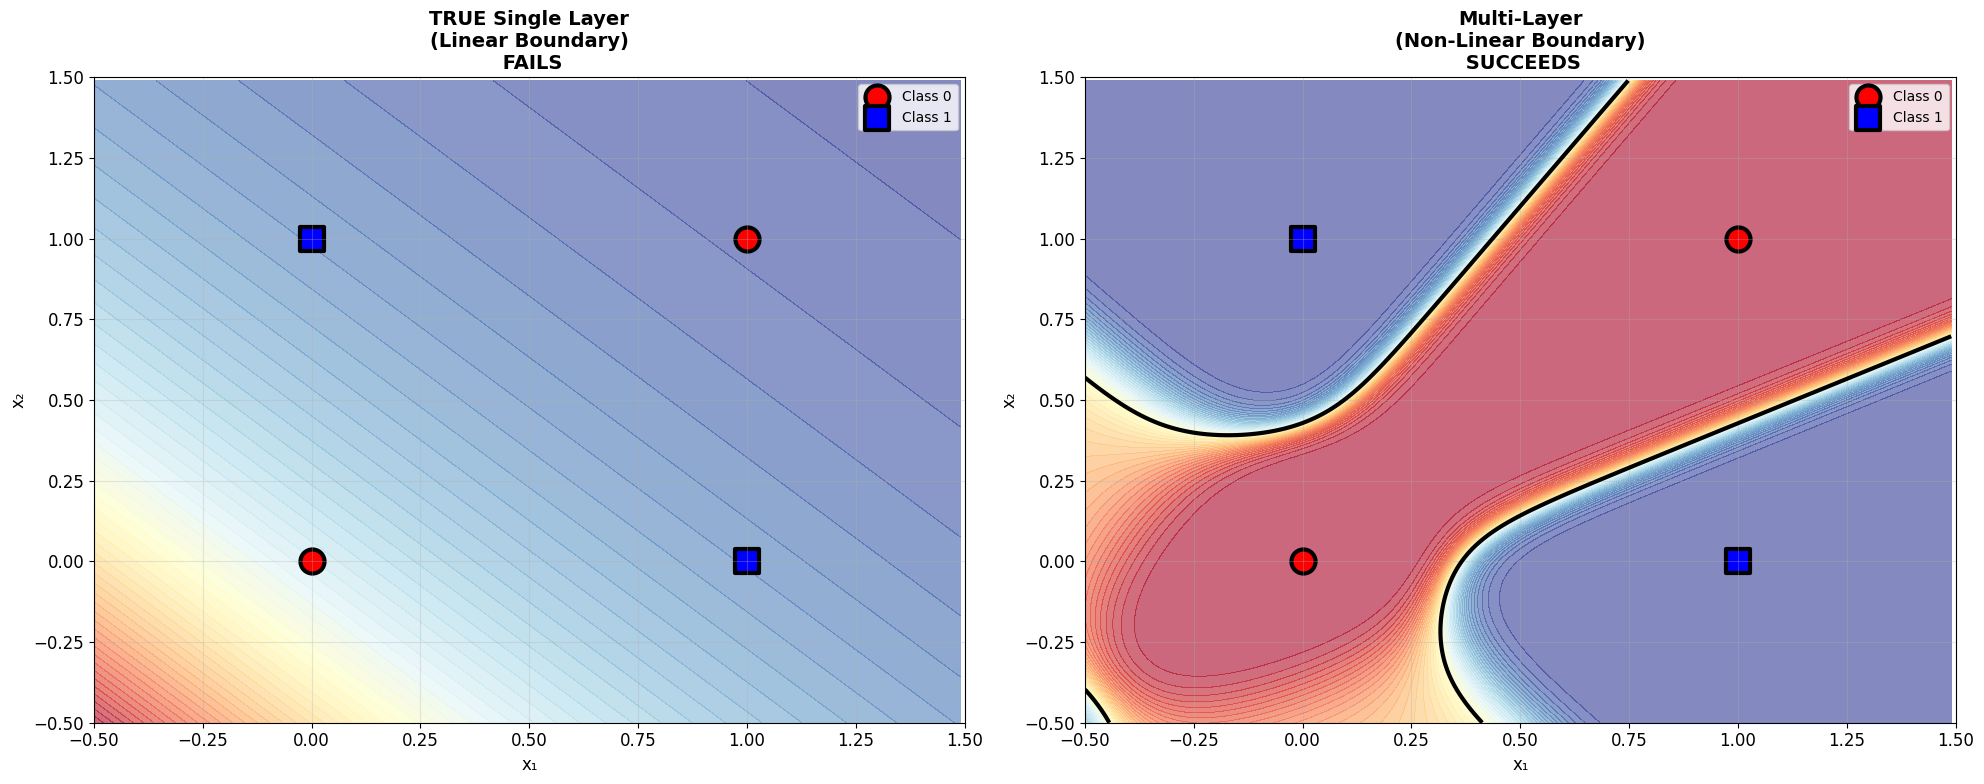

OBSERVATION:
• TRUE Single Layer: Can only create a straight line (linear boundary)
• Multi-Layer: Creates curved boundaries that can separate XOR classes
• Deep Network: Can create even more complex boundaries


In [14]:
# Visualize decision boundaries
def plot_decision_boundary(model, title, ax):
    h = 0.01
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid_points).numpy()
    Z = Z.reshape(xx.shape)
    
    # Create contour plot
    contour = ax.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=3, linestyles='-')
    
    # Plot XOR points
    colors = ['red', 'blue']
    markers = ['o', 's']
    for i in range(2):
        mask = y_xor.flatten() == i
        ax.scatter(X_xor[mask, 0], X_xor[mask, 1], 
                  c=colors[i], s=300, alpha=1.0, 
                  edgecolors='black', linewidth=3,
                  marker=markers[i], label=f'Class {i}')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Create the comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# True single layer (should show linear boundary)
plot_decision_boundary(true_single, 'TRUE Single Layer\n(Linear Boundary)\n FAILS', ax1)

# Multi-layer (should solve XOR)
plot_decision_boundary(multi_layer, 'Multi-Layer\n(Non-Linear Boundary)\n SUCCEEDS', ax2)

plt.tight_layout()
plt.show()

print("OBSERVATION:")
print("• TRUE Single Layer: Can only create a straight line (linear boundary)")
print("• Multi-Layer: Creates curved boundaries that can separate XOR classes")
print("• Deep Network: Can create even more complex boundaries")

## Mathematical Explanation: Why Depth Solves XOR

### The Problem with True Single-Layer Perceptrons

A true single-layer perceptron computes:
$y = \sigma(w_1 x_1 + w_2 x_2 + b)$

The decision boundary is defined by $w_1 x_1 + w_2 x_2 + b = 0$, which is always a **straight line**. 

For XOR, we need to separate:
- Class 0: (0,0) and (1,1) 
- Class 1: (0,1) and (1,0)

No single straight line can accomplish this separation!

### The Solution: Multi-Layer Networks

A multi-layer network can solve XOR by decomposing it into simpler problems:

**Layer 1 (Hidden)**: Create intermediate features
- $h_1 = \sigma(w_{11} x_1 + w_{12} x_2 + b_1)$ ≈ $x_1$ OR $x_2$
- $h_2 = \sigma(w_{21} x_1 + w_{22} x_2 + b_2)$ ≈ $x_1$ AND $x_2$

**Layer 2 (Output)**: Combine features
- $y = \sigma(v_1 h_1 + v_2 h_2 + b_3)$ ≈ OR AND NOT = XOR

This demonstrates the **compositional power** of depth: complex functions can be built from simpler components.

## Beyond XOR: High-Frequency Functions

The limitations of shallow networks extend beyond simple classification. Let's see how they struggle with high-frequency functions:

In [15]:
# High-frequency function demonstration
def high_freq_function(x):
    return np.sin(np.pi * x) + 0.3 * np.sin(10 * np.pi * x)

x_hf = np.linspace(0, 1, 100)
y_hf_true = high_freq_function(x_hf)

# Training data (sparse sampling)
np.random.seed(42)
x_hf_train = np.linspace(0, 1, 25)
y_hf_train = high_freq_function(x_hf_train) + 0.01 * np.random.randn(25)

x_hf_train_t = torch.tensor(x_hf_train.reshape(-1, 1), dtype=torch.float32)
y_hf_train_t = torch.tensor(y_hf_train.reshape(-1, 1), dtype=torch.float32)
x_hf_test_t = torch.tensor(x_hf.reshape(-1, 1), dtype=torch.float32)

# Network architectures for regression
class ShallowRegressor(nn.Module):
    """Single hidden layer for regression"""
    def __init__(self, width=50):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, 1)
        )
    
    def forward(self, x):
        return self.network(x)

class DeepRegressor(nn.Module):
    """Multiple hidden layers for regression"""
    def __init__(self, width=20, depth=3):
        super().__init__()
        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth-1):
            layers.extend([nn.Linear(width, width), nn.Tanh()])
        layers.append(nn.Linear(width, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_regressor(model, x_train, y_train, epochs=3000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        pred = model(x_train)
        loss = criterion(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.item()

# Train models
print("Training regressors on high-frequency function...")
torch.manual_seed(42)
shallow_reg = ShallowRegressor(100)  # More neurons to be fair
deep_reg = DeepRegressor(20, 4)      # Fewer neurons but more layers

shallow_loss = train_regressor(shallow_reg, x_hf_train_t, y_hf_train_t)
deep_loss = train_regressor(deep_reg, x_hf_train_t, y_hf_train_t)

print(f"Shallow network final loss: {shallow_loss:.6f}")
print(f"Deep network final loss: {deep_loss:.6f}")
print(f"Improvement factor: {shallow_loss/deep_loss:.2f}x")

Training regressors on high-frequency function...
Shallow network final loss: 0.043165
Deep network final loss: 0.000006
Improvement factor: 6731.94x


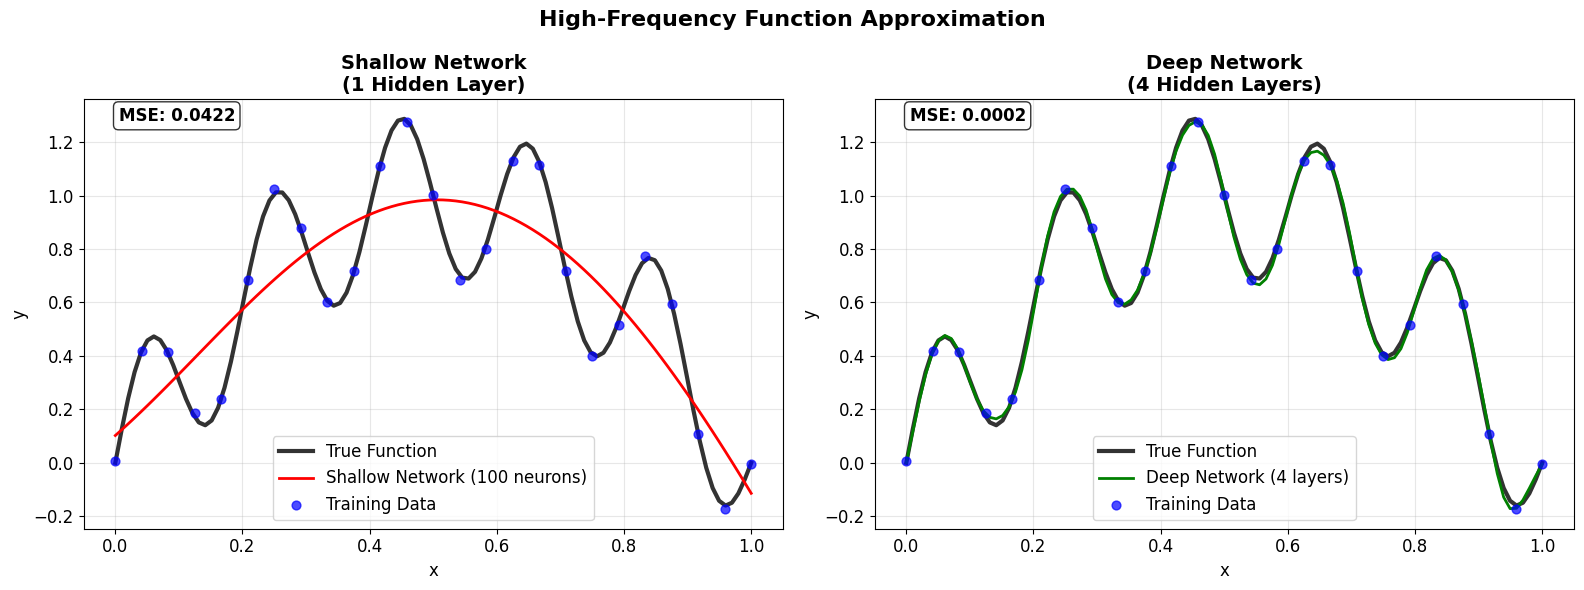


RESULTS COMPARISON:
Shallow network MSE: 0.042184
Deep network MSE: 0.000221
Deep network is 190.5× better!

The deep network captures high-frequency components much better.


In [16]:
# Visualize high-frequency function results
with torch.no_grad():
    y_shallow_pred = shallow_reg(x_hf_test_t).numpy().flatten()
    y_deep_pred = deep_reg(x_hf_test_t).numpy().flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Shallow network result
ax1.plot(x_hf, y_hf_true, 'k-', linewidth=3, label='True Function', alpha=0.8)
ax1.plot(x_hf, y_shallow_pred, 'r-', linewidth=2, label='Shallow Network (100 neurons)')
ax1.scatter(x_hf_train, y_hf_train, color='blue', s=40, alpha=0.7, zorder=5, label='Training Data')

shallow_mse = np.mean((y_shallow_pred - y_hf_true)**2)
ax1.text(0.05, 0.95, f'MSE: {shallow_mse:.4f}', transform=ax1.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=12, fontweight='bold')

ax1.set_title('Shallow Network\n(1 Hidden Layer)', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Deep network result
ax2.plot(x_hf, y_hf_true, 'k-', linewidth=3, label='True Function', alpha=0.8)
ax2.plot(x_hf, y_deep_pred, 'g-', linewidth=2, label='Deep Network (4 layers)')
ax2.scatter(x_hf_train, y_hf_train, color='blue', s=40, alpha=0.7, zorder=5, label='Training Data')

deep_mse = np.mean((y_deep_pred - y_hf_true)**2)
ax2.text(0.05, 0.95, f'MSE: {deep_mse:.4f}', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=12, fontweight='bold')

ax2.set_title('Deep Network\n(4 Hidden Layers)', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.suptitle('High-Frequency Function Approximation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nRESULTS COMPARISON:")
print(f"Shallow network MSE: {shallow_mse:.6f}")
print(f"Deep network MSE: {deep_mse:.6f}")
print(f"Deep network is {shallow_mse/deep_mse:.1f}× better!")
print("\nThe deep network captures high-frequency components much better.")

## Key Insights: Why Depth Matters

### 1. **Representation Efficiency**
- **Shallow networks**: Require exponentially many neurons for complex patterns
- **Deep networks**: Hierarchical feature composition is exponentially more efficient

### 2. **Feature Hierarchy**
- **Layer 1**: Simple features (edges, basic patterns)
- **Layer 2**: Combinations of simple features (corners, textures)
- **Layer 3+**: Complex abstractions (objects, concepts)

### 3. **Geometric Perspective**
- Each layer performs a **coordinate transformation**
- Deep networks can "unfold" complex manifolds
- **XOR example**: Transform non-separable data into separable representation

### 4. **Practical Implications**
- **Universal approximation ≠ efficient approximation**
- **Depth enables compositional learning**
- **Real-world functions often have hierarchical structure**

## Historical Timeline and Impact

| Year | Event | Impact |
|------|-------|--------|
| 1943 | McCulloch-Pitts neuron | Foundation of neural networks |
| 1957 | Rosenblatt's Perceptron | First learning algorithm |
| **1969** | **Minsky & Papert critique** | **Showed single-layer limitations (XOR)** |
| 1970s-80s | "AI Winter" | Reduced funding and interest |
| 1986 | Backpropagation | Enabled training of multi-layer networks |
| 2006+ | Deep Learning Revolution | Showed power of very deep networks |

## Summary

The XOR problem reveals fundamental limitations of **true** single-layer perceptrons:

### ❌ **Single-Layer Limitations**:
1. **Linear separability constraint**: Can only create straight-line boundaries
2. **Cannot solve XOR**: Accuracy stuck around 50% (random guessing)
3. **Limited expressiveness**: Cannot represent complex functions efficiently

### ✅ **Multi-Layer Solutions**:
1. **Non-linear transformations**: Hidden layers enable curved boundaries
2. **Solves XOR perfectly**: 100% accuracy achievable
3. **Hierarchical representations**: Complex patterns from simple building blocks
4. **Efficiency gains**: Often requires fewer total parameters than wide shallow networks

### 🌟 **Modern Relevance**:
**Historical impact**: Understanding these limitations led to the deep learning revolution, showing that depth is not just helpful but **essential** for many real-world problems.

**Today's applications**: These principles scale to:
- **Computer Vision**: Hierarchical feature detection (edges → shapes → objects)
- **Natural Language Processing**: From characters → words → sentences → meaning
- **Scientific Computing**: Multi-scale physical phenomena
- **Anywhere hierarchical pattern recognition is needed**

The XOR problem, while simple, encapsulates one of the most important insights in machine learning: **depth transforms impossible problems into solvable ones**.